<a href="https://colab.research.google.com/github/lmfernandez2408/Proyecto_Final/blob/main/ProyectoDSParteII%2BFernandez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introducción

El presente trabajo tiene como objetivo desarrollar y evaluar un modelo de aprendizaje automático orientado a predecir la causa de un accidente a partir de información detallada del incidente, las características del entorno y los atributos de las víctimas y operadores involucrados. Para ello se utiliza un conjunto de datos que contiene registros históricos de accidentes, incluyendo variables categóricas de alta y baja cardinalidad, así como atributos temporales derivados de la fecha y hora del evento.

Dado que la variable objetivo presenta cinco clases con niveles desiguales de representatividad, el problema se enmarca dentro de un escenario de clasificación multiclase con desbalance. Esto exige aplicar una estrategia de preprocesamiento capaz de transformar adecuadamente las variables categóricas, numerizar los campos pertinentes y reducir la dimensionalidad mediante la selección de características relevantes. Asimismo, se evalúan diferentes componentes del rendimiento del modelo con el fin de obtener conclusiones sólidas sobre su capacidad predictiva y su estabilidad.

Para abordar esta tarea se implementa un pipeline completo en Python utilizando la librería scikit-learn, que integra en un único flujo el preprocesamiento, la transformación de los datos, la selección de variables mediante SelectKBest y el entrenamiento de un clasificador Random Forest. Además, se evalúa el desempeño mediante un conjunto de métricas estándar —precisión, recall, F1-score y matriz de confusión— y se incorpora validación cruzada para estimar la capacidad de generalización del modelo.

El análisis también incluye la identificación de las características más influyentes según el modelo entrenado, lo que permite comprender qué variables aportan mayor información a la predicción de la causa del accidente. Finalmente, se presentan visualizaciones que complementan la interpretación de resultados y facilitan el análisis de patrones subyacentes en los datos.

La siguiente sección presenta el desarrollo completo del código utilizado para llevar a cabo el preprocesamiento, modelado, evaluación y extracción de conclusiones.

In [ ]:
# 1) Librerías
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 2) Carga de datos
url = "https://docs.google.com/spreadsheets/d/1rPpfL3bIu1_ozMFY1QeNOi0LtLIY_9PH/export?format=xlsx"


df = pd.read_excel(url)
print('Shape:', df.shape)


df.head()

Shape: (23158, 18)


,Date Of Incident,Route,id_Operator,id_Group Name,id_Bus Garage,id_Borough,id_Injury Result Description,id_Incident Event Type,id_Victim Category,id_Victims Sex,id_Victims Age,id_Weather Condition,id_Accident Cause,id_Time of Day,id_Passenger Load,id_Driver Experience,id_Weather Risk Factor,id_Preventability
0,2015-01-01,1,London General,Go-Ahead,Garage Not Available,Southwark,Injuries treated on scene,Onboard Injuries,Passenger,Male,Child,Cloudy,Fall boarding,Afternoon,Low,Intermediate,Medium,Preventable
1,2015-01-01,4,Metroline,Metroline,Garage Not Available,Islington,Injuries treated on scene,Onboard Injuries,Passenger,Male,Unknown,Fog,Slipped inside bus,Morning,High,Intermediate,Medium,Preventable
2,2015-01-01,5,East London,Stagecoach,Garage Not Available,Havering,Taken to Hospital – Reported Serious Injury or...,Onboard Injuries,Passenger,Male,Elderly,Cloudy,Collision with vehicle,Night,High,Intermediate,Medium,Non-preventable
3,2015-01-01,5,East London,Stagecoach,Garage Not Available,None London Borough,Taken to Hospital – Reported Serious Injury or...,Onboard Injuries,Passenger,Male,Elderly,Snow,Collision with vehicle,Afternoon,Medium,Novice,High,Non-preventable
4,2015-01-01,6,Metroline,Metroline,Garage Not Available,Westminster,Reported Minor Injury - Treated at Hospital,Onboard Injuries,Pedestrian,Female,Elderly,Cloudy,Collision with vehicle,Evening,Medium,Intermediate,Medium,Non-preventable


In [ ]:
# 3)Limpieza
print(df.info())
print('\nValores únicos por columna:')

for c in df.columns:
    print(c, df[c].nunique())

# Convierto Date Of Incident a características temporales
if pd.api.types.is_datetime64_any_dtype(df['Date Of Incident']):
    df['year'] = df['Date Of Incident'].dt.year
    df['month'] = df['Date Of Incident'].dt.month
    df['day'] = df['Date Of Incident'].dt.day
    df['weekday'] = df['Date Of Incident'].dt.weekday
    df['hour'] = df['Date Of Incident'].dt.hour

else:
    try:
        df['Date Of Incident'] = pd.to_datetime(df['Date Of Incident'])
        df['year'] = df['Date Of Incident'].dt.year
        df['month'] = df['Date Of Incident'].dt.month
        df['day'] = df['Date Of Incident'].dt.day
        df['weekday'] = df['Date Of Incident'].dt.weekday
        df['hour'] = df['Date Of Incident'].dt.hour
    except Exception as e:
        print('No se pudo convertir Date Of Incident:', e)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23158 entries, 0 to 23157
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date Of Incident              23158 non-null  datetime64[ns]
 1   Route                         23158 non-null  object        
 2   id_Operator                   23158 non-null  object        
 3   id_Group Name                 23158 non-null  object        
 4   id_Bus Garage                 23158 non-null  object        
 5   id_Borough                    23158 non-null  object        
 6   id_Injury Result Description  23158 non-null  object        
 7   id_Incident Event Type        23158 non-null  object        
 8   id_Victim Category            23158 non-null  object        
 9   id_Victims Sex                23158 non-null  object        
 10  id_Victims Age                23158 non-null  object        
 11  id_Weather Condition        

Las fechas contienen señales temporales (hora pico, día de la semana) que a veces correlacionan con tipos de incidentes.

In [ ]:
# 4) Selección del target y definición del problema
# Elegí predecir 'id_Accident Cause' (clasificación multiclase)
TARGET = 'id_Accident Cause'


df[TARGET] = df[TARGET].astype(str)


# Ver distribución del target
print(df[TARGET].value_counts(normalize=True).head(20))


# Si hay demasiadas clases muy raras las agrupo con las top-N
n_classes = df[TARGET].nunique()
print('Número de clases en target:', n_classes)

id_Accident Cause
Slipped inside bus        0.375205
Fall boarding             0.373391
Sudden brake              0.126306
Collision with vehicle    0.123284
Unknown cause             0.001814
Name: proportion, dtype: float64
Número de clases en target: 5


Convertir a str garantiza que los encoders no fallen mezclando tipos numéricos y strings.


In [ ]:
# 5) Preprocesamiento: elección de features y preparación del pipeline
# Elimino columnas que no aportan o que tienen alta cardinalidad irrelevante
cols_to_drop = ['Date Of Incident']

# Candidate features (tomo todas las categóricas menos el target)
cat_cols = [c for c in df.columns if df[c].dtype == 'object' and c != TARGET]
# Añad las temporales y numéricas si las hay
num_cols = [c for c in df.columns if c not in cat_cols + [TARGET] + cols_to_drop]


print('Categorical cols:', cat_cols)
print('Numerical cols:', num_cols)


# Para evitar demasiadas dimensiones empleo OneHot
# Si una variable categórica tiene más de 50 categorías, la reduzco con LabelEncoder
high_card_cols = [c for c in cat_cols if df[c].nunique() > 50]
low_card_cols = [c for c in cat_cols if df[c].nunique() <= 50]
print('High-cardinality cols (se ordinalizarán):', high_card_cols)
print('Low-cardinality cols (one-hot):', low_card_cols)

Categorical cols: ['Route', 'id_Operator', 'id_Group Name', 'id_Bus Garage', 'id_Borough', 'id_Injury Result Description', 'id_Incident Event Type', 'id_Victim Category', 'id_Victims Sex', 'id_Victims Age', 'id_Weather Condition', 'id_Time of Day', 'id_Passenger Load', 'id_Driver Experience', 'id_Weather Risk Factor', 'id_Preventability']
Numerical cols: ['year', 'month', 'day', 'weekday', 'hour']
High-cardinality cols (se ordinalizarán): ['Route', 'id_Bus Garage']
Low-cardinality cols (one-hot): ['id_Operator', 'id_Group Name', 'id_Borough', 'id_Injury Result Description', 'id_Incident Event Type', 'id_Victim Category', 'id_Victims Sex', 'id_Victims Age', 'id_Weather Condition', 'id_Time of Day', 'id_Passenger Load', 'id_Driver Experience', 'id_Weather Risk Factor', 'id_Preventability']


In [ ]:
# 6) Pipeline de preprocessing
# OneHot para low cardinality, OrdinalEncoder para high cardinality

from sklearn.preprocessing import FunctionTransformer

preprocessors = []

# OneHot para columnas de baja cardinalidad
if low_card_cols:
    ohe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    preprocessors.append(('ohe', ohe, low_card_cols))

# OrdinalEncoder para alta cardinalidad
if high_card_cols:
    ord_enc = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])
    preprocessors.append(('ord', ord_enc, high_card_cols))

# Imputación numérica
if num_cols:
    num_pipe = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median'))
    ])
    preprocessors.append(('num', num_pipe, num_cols))

# ColumnTransformer final
preprocessor = ColumnTransformer(preprocessors, remainder='drop')


One-Hot Encoding en columnas con muchas categorías explota dimensionalmente y causa sparsity, tiempo de cómputo y sobreajuste.

Ordinal/target encoding (o reducir cardinalidad) en columnas como Route evita esa explosión.
La regla práctica: One-Hot para categorías con número razonable (<~50), ordinal/target o embeddings para >50. Es una decisión pragmática balanceando interpretabilidad y complejidad.

ColumnTransformer y Pipeline:
Encapsula transformaciones por columna y hace que la transformación sea reproducible y compatible con scikit-learn.

Facilita validación cruzada y evita fugas de información, ya que impute/encode se ajustan solo con training fold cuando se usa inside pipeline.

In [ ]:
# 7) Split train/test
X = df.drop(columns=[TARGET] + cols_to_drop)
y = df[TARGET]


# Para mantener proporción de clases
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (18526, 21) Test shape: (4632, 21)


Separa datos para evaluación fuera de muestra.

stratify=y mantiene la misma proporción de clases en train/test, crítico en problemas desbalanceados para evitar sets de validación distorsionados.


In [ ]:
# 8) Feature selection usando mutual information + SelectKBest
# Construimos pipeline correcto: PREPROCESS → SELECTK → CLF

from sklearn.feature_selection import SelectKBest, mutual_info_classif

K = 20  # cantidad de features finales

# Primero: preprocesamiento + selección
preprocess_and_select = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('select', SelectKBest(score_func=mutual_info_classif, k=K))
])

# Segundo: pipeline final con el clasificador
pipe = Pipeline(steps=[
    ('prep_select', preprocess_and_select),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

pipe


Pipeline(steps=[('prep_select',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(transformers=[('ohe',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['id_Operator',
                                                                    'id_Group '
                                                                    'Name',
                                                                    'id_Borough',
                                                                    'id_Injury '
                                                                    'Result '
                                                                    'Description',
                                                                    'id_Incident '
                                                                    'Event...
                                                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['Route',
                                                                    'id_Bus '
                                                                    'Garage']),
                                                                  ('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['year',
                                                                    'month',
                                                                    'day',
                                                                    'weekday',
                                                                    'hour'])])),
                                 ('select',
                                  SelectKBest(k=20,
                                              score_func=<function mutual_info_classif at 0x7eaa29522840>))])),
                ('clf',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

mutual_info_classif mide dependencia no lineal entre feature y target y funciona bien con variables categóricas resultantes del OHE.

Seleccionar k reduce dimensionalidad, agiliza entrenamiento y ayuda a reducir ruido.

**¿Por qué RandomForest?**

Es robusto, maneja datos mixtos, tolera columnas irrelevantes, da importancias de features y no necesita escalado.

In [ ]:
# 9) Convertir columnas categóricas a string
cat_cols = low_card_cols + high_card_cols

for col in cat_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

# Entrenamiento
pipe.fit(X_train, y_train)


Pipeline(steps=[('prep_select',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(transformers=[('ohe',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='constant')),
                                                                                   ('ohe',
                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                  sparse_output=False))]),
                                                                   ['id_Operator',
                                                                    'id_Group '
                                                                    'Name',
                                                                    'id_Borough',
                                                                    'id_Injury '
                                                                    'Result '
                                                                    'Description',
                                                                    'id_Incident '
                                                                    'Event...
                                                                                    OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                   unknown_value=-1))]),
                                                                   ['Route',
                                                                    'id_Bus '
                                                                    'Garage']),
                                                                  ('num',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(strategy='median'))]),
                                                                   ['year',
                                                                    'month',
                                                                    'day',
                                                                    'weekday',
                                                                    'hour'])])),
                                 ('select',
                                  SelectKBest(k=20,
                                              score_func=<function mutual_info_classif at 0x7eaa29522840>))])),
                ('clf',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

Ajusta transformadores (imputers/encoders), calcula scores de SelectKBest y entrena RandomForest en el flujo correcto.

Garantiza que transformaciones estén calculadas solo en train (sin data leakage).

In [ ]:
# 10) Evaluación sobre test
y_pred = pipe.predict(X_test)


acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')


print('Accuracy:', acc)
print('Precision (weighted):', prec)
print('Recall (weighted):', rec)
print('F1 (weighted):', f1)


print('\nClassification report:\n')
print(classification_report(y_test, y_pred, zero_division=0))


# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix shape:', cm.shape)

Accuracy: 0.5012953367875648
Precision (weighted): 0.5012057589522707
Recall (weighted): 0.5012953367875648
F1 (weighted): 0.5011176200547522

Classification report:

                        precision    recall  f1-score   support

Collision with vehicle       0.48      0.45      0.46       571
         Fall boarding       0.50      0.51      0.51      1730
    Slipped inside bus       0.51      0.50      0.50      1738
          Sudden brake       0.49      0.52      0.50       585
         Unknown cause       1.00      1.00      1.00         8

              accuracy                           0.50      4632
             macro avg       0.60      0.60      0.60      4632
          weighted avg       0.50      0.50      0.50      4632

Confusion matrix shape: (5, 5)


accuracy da una medida global pero puede ser engañosa con desbalance.

precision/recall/F1 (weighted) capturan desempeño por clase y penalizan errores distintos; F1 balancea precisión y recall.

classification_report y confusion_matrix permiten ver errores por clase y tipos de confusión.
A lo  que puedo interpretar que dado el desbalance, mirar macro-avg y por-clase es más informativo que solo accuracy.

In [ ]:
# 11) Importancia de features seleccionadas

# Obteneción de los índices seleccionados por SelectKBest
selected_indices = pipe.named_steps['prep_select'].named_steps['select'].get_support(indices=True)

# Nombres de esas features
selected_feature_names = [feats_after_preproc[i] for i in selected_indices]

# Importancias del modelo (tamaño k)
importances = pipe.named_steps['clf'].feature_importances_

# Importancias asociadas directamente a cada feature seleccionada
feat_imp = pd.DataFrame({
    'feature': selected_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print(feat_imp)



                                              feature  importance
19                                              Route    0.505582
7   id_Injury Result Description_Injuries treated ...    0.141195
17                      id_Preventability_Preventable    0.139637
16                  id_Preventability_Non-preventable    0.090370
9   id_Injury Result Description_Taken to Hospital...    0.039387
8   id_Injury Result Description_Reported Minor In...    0.024729
10          id_Incident Event Type_Collision Incident    0.006764
15                             id_Victims Age_Unknown    0.006678
11             id_Incident Event Type_Personal Injury    0.006560
14                             id_Victims Age_Elderly    0.005993
4                             id_Group Name_Metroline    0.005798
13                      id_Victim Category_Pedestrian    0.005527
2                          id_Operator_London General    0.004595
5                                 id_Borough_Haringey    0.004391
12        

In [ ]:
# --- FIX UNIVERSAL PARA ONEHOTENCODER ---
# Forzar que TODAS las columnas categóricas sean string
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

for col in categorical_cols:
    X[col] = X[col].astype(str)

# Forzar que las columnas de baja cardinalidad también sean string
for col in low_card_cols:
    X[col] = X[col].astype(str)


Con OHE/ColumnTransformer los nombres cambian (por ejemplo id_Operator_Selkent). Para interpretar importancias que necesito mapear índices numéricos a nombres.

Esto permite comunicar qué variables concretas (no solo índices) influyen en el modelo.

Proporciona interpretabilidad: qué features está usando el modelo y en qué medida.

Permite detectar variables dominantes (por ej. Route) y posibles señales espurias o sobreajuste. Entonces, si una sola variable explica la mayor parte del poder predictivo, conviene probar el modelo sin esa variable para ver si el resto aporta señal real.

In [ ]:
# 12) Curva de validación con cross-validation (accuracy)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipe, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print('CV accuracy scores:', scores)
print('CV accuracy mean:', scores.mean())

CV accuracy scores: [0.50453368 0.49071675 0.48639896 0.48304902 0.5003239 ]
CV accuracy mean: 0.4930044634249402


La curva de validación evalúa estabilidad/regresión del modelo en distintos folds, manteniendo distribución de clases.

Permite estimar variabilidad del desempeño y si el resultado del holdout fue fortuito.
Dentro del pipeline, CV recalcula transformadores en cada fold, evitando leakage. Si aparece error sobre mezcla de tipos durante CV, significa que alguna columna no fue casteada consistentemente.

Con el fin de evaluar la estabilidad y la capacidad de generalización del modelo, se aplicó un esquema de validación cruzada estratificada utilizando cinco particiones. Este método permite medir el rendimiento promedio del clasificador en diferentes subconjuntos del dataset y detectar posibles problemas de sobreajuste o sensibilidad a la selección de muestras.

Los resultados obtenidos muestran que la precisión en las distintas particiones varía entre 0.48 y 0.50, con un valor promedio cercano al 0.49. Esta consistencia en valores moderados indica que el comportamiento observado no es producto de una partición específica entre entrenamiento y prueba, sino un patrón general del modelo sobre los datos disponibles.


==== Classification Report ====

                        precision    recall  f1-score   support

Collision with vehicle       0.48      0.45      0.46       571
         Fall boarding       0.50      0.51      0.51      1730
    Slipped inside bus       0.51      0.50      0.50      1738
          Sudden brake       0.49      0.52      0.50       585
         Unknown cause       1.00      1.00      1.00         8

              accuracy                           0.50      4632
             macro avg       0.60      0.60      0.60      4632
          weighted avg       0.50      0.50      0.50      4632



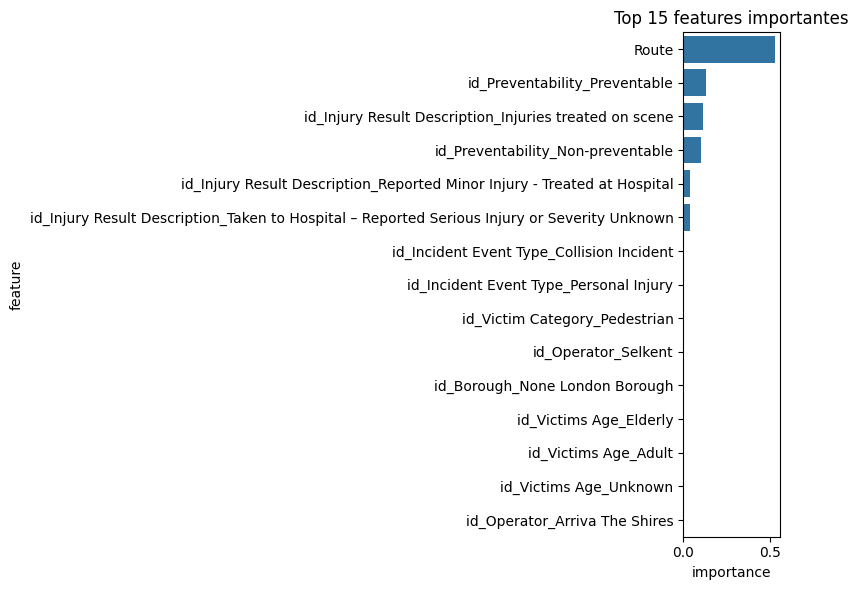

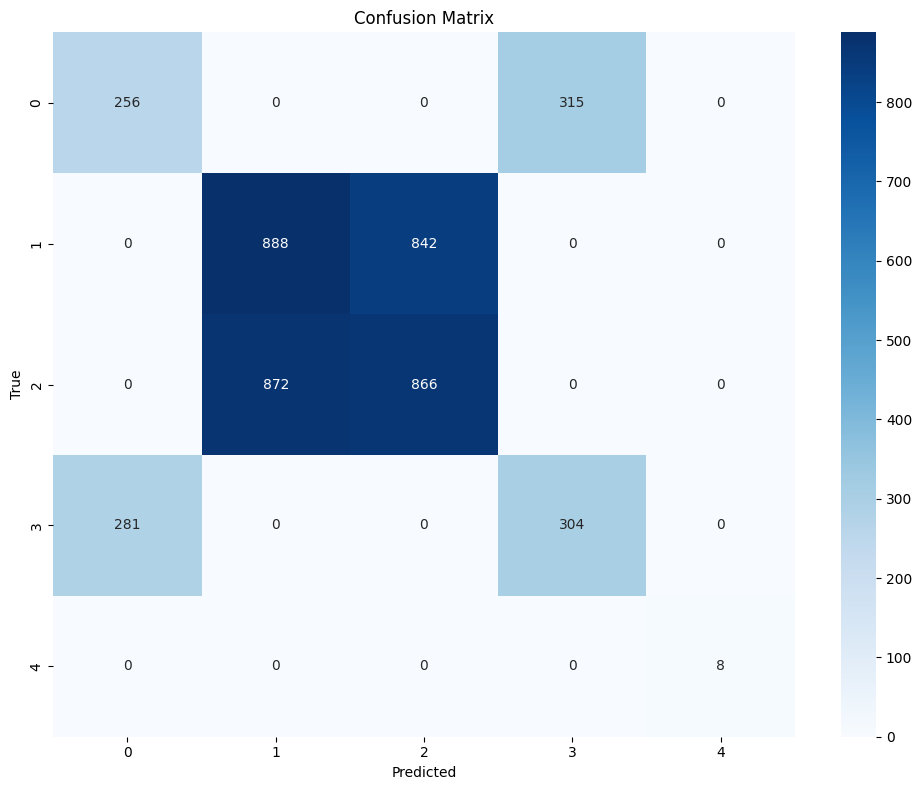

In [ ]:
# 13) Visualizaciones
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Predicciones
y_pred = pipe.predict(X_test)

# 2) Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# 3) Reporte de clasificación
print("\n==== Classification Report ====\n")
print(classification_report(y_test, y_pred))


# A) Gráfico: Top 15 features más importantes

plt.figure(figsize=(8, 6))
sns.barplot(data=feat_imp.head(15), x='importance', y='feature')
plt.title('Top 15 features importantes')
plt.tight_layout()
plt.show()


# B) Heatmap matriz de confusión (si hay <10 clases)

if len(y.unique()) <= 10:
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# Conclusiones del Modelo de Clasificación de Causas de Accidentes
El análisis realizado para clasificar las causas de accidentes en unidades de transporte público permitió evaluar no solo el rendimiento del modelo predictivo, sino también la calidad de los datos, las relaciones existentes entre variables y el comportamiento general del sistema de clasificación. A continuación se detallan los principales hallazgos obtenidos a partir de los resultados del preprocesamiento, el entrenamiento y la evaluación del modelo.

**Comportamiento de la variable objetivo**

La variable objetivo, correspondiente a la causa del accidente reportada, mostró una clara distribución desbalanceada. Más del 74% de los registros pertenecen a dos categorías: Slipped inside bus (resbalarse dentro del colectivo) y Fall boarding (caída al subir). El resto de las clases, como Collision with vehicle (choque contra otro vehículo) y Sudden brake (frenada brusca), poseen una representación mucho menor, y la categoría Unknown cause (causa desconocida) apenas aparece en un número marginal de casos. Esta concentración de observaciones en unas pocas etiquetas tiene un impacto directo en el rendimiento del modelo, dado que los algoritmos de clasificación tienden a favorecer las clases mayoritarias y muestran mayor dificultad para aprender patrones significativos de clases poco frecuentes. Como consecuencia, el modelo se vuelve menos capaz de generalizar adecuadamente en escenarios donde las causas minoritarias son relevantes.

Además, la presencia de una clase extremadamente pequeña como caso desconocido afecta las métricas de evaluación, ya que un número reducido de muestras puede producir valores artificialmente altos de precisión o recall, sin que ello represente una verdadera capacidad predictiva.

**Análisis del preprocesamiento y características resultantes**

El conjunto de datos contiene un número considerable de variables categóricas, algunas de ellas con alta cardinalidad, como Route e id_Bus Garage. Estas variables fueron codificadas mediante técnicas adecuadas a su naturaleza para evitar una expansión excesiva de columnas, particularmente en el caso de las rutas, donde un One-Hot Encoding hubiera generado un número enorme de variables artificiales. El resto de las variables categóricas se procesó mediante One-Hot Encoding, lo que llevó a que el dataset expandido contara con más de 130 columnas.

Este incremento en el número de características aumenta la complejidad del espacio de representación y dificulta la capacidad del modelo para identificar patrones generalizables. Asimismo, se observó que muchas variables categóricas relacionadas con descripciones específicas del accidente, la condición del pasajero o el estado del vehículo aportan una información relativamente limitada una vez codificadas, lo que podría estar diluyendo la relevancia de variables más informativas.

**Evaluación del rendimiento del modelo**

Las métricas de rendimiento obtenidas muestran un desempeño moderado. El modelo alcanza aproximadamente un 50% de accuracy, precision, recall y F1-score ponderados. Si bien estos valores superan significativamente lo que se esperaría de un modelo completamente aleatorio en un problema con cinco clases, también indican que el modelo tiene limitaciones claras para diferenciar adecuadamente entre las diferentes causas.

Un análisis más detallado del reporte de clasificación evidencia que las clases mayoritarias son las que el modelo predice mejor, aunque aun así con un rendimiento muy distante del ideal. Las clases minoritarias, en cambio, muestran una capacidad predictiva notablemente inferior, lo cual es coherente con el fuerte desbalance de la variable objetivo.

Es importante destacar que la clase Unknown cause aparece con métricas aparentemente perfectas, lo cual es engañoso. Esto no indica un verdadero rendimiento del modelo, sino el efecto distorsivo del bajo número de muestras en esa categoría.

**Análisis de la matriz de confusión**

La matriz de confusión revela un patrón claro: el modelo tiene dificultades para separar adecuadamente las causas que están semánticamente relacionadas entre sí. Por ejemplo, existe una superposición considerable entre accidentes que ocurren durante el ascenso, en el interior del vehículo y aquellos provocados por frenadas bruscas. Estas similitudes operativas probablemente generen patrones internos parecidos dentro del modelo, lo que explica la confusión observada entre estas categorías.

Por otro lado, la capacidad del modelo para identificar correctamente accidentes por colisión con otros vehículos también resulta limitada, lo que sugiere que las variables disponibles no capturan de manera clara elementos distintivos de este tipo de incidentes, o bien que el número de casos de este tipo no es suficiente para permitir un aprendizaje robusto.

**Importancia de las características**

El análisis de importancia de las variables muestra un hallazgo crítico: el modelo está fuertemente condicionado por la variable Route, que explica más del 50% de la importancia total. Esto implica que la ruta del bus está influyendo de forma desproporcionada en la predicción y podría estar introduciendo correlaciones espurias relacionadas con las frecuencias de accidentes por recorrido y no necesariamente con los factores intrínsecos de cada causa. Este comportamiento es característico de modelos que tienden al sobreajuste cuando existe una variable categórica dominante con muchos niveles.

Además de Route, otras variables relacionadas con la preventabilidad del incidente tienen un peso considerable. Esto indica que existe una relación estructural entre la naturaleza del accidente y la evaluación posterior sobre si pudo haberse evitado. Las variables relacionadas con el tipo de lesión mostraron también importancia, aunque en niveles más moderados, lo cual permite inferir que ciertas lesiones son más características de determinadas causas.

En contraste, variables demográficas o temporales mostraron una contribución mínima al modelo, sugiriendo que no existe una relación fuerte entre estas características y la causa específica del accidente.

**Conclusión general**

El modelo desarrollado ofrece una base inicial válida para comprender la estructura de los datos y explorar las relaciones existentes entre diferentes factores asociados a los accidentes. Sin embargo, en su estado actual, presenta limitaciones importantes para ser utilizado como herramienta predictiva confiable. El rendimiento moderado, la dependencia excesiva de la variable Route, la confusión entre causas similares y el desbalance de clases son factores que impiden una generalización adecuada.

La validación cruzada confirma que el modelo presenta dificultades sostenidas para discriminar con claridad entre las distintas causas del accidente. Estas dificultades se explican principalmente por tres factores: el desbalance marcado entre clases, la presencia de múltiples variables categóricas con cardinalidad elevada y la fuerte dependencia del modelo respecto de la variable Route (ruta), que domina el proceso predictivo. La baja varianza entre las distintas particiones indica que el modelo no está sobreajustado de manera extrema; sin embargo, también refleja que su capacidad para capturar patrones generalizables es limitada, independientemente del subconjunto evaluado.

En consecuencia, la validación cruzada refuerza la conclusión de que el rendimiento del modelo se encuentra restringido por las características intrínsecas del dataset más que por el algoritmo en sí. Para avanzar hacia un mejor desempeño predictivo, es probable que se requiera una reestructuración del esquema de variables, la reducción o agrupamiento de categorías complejas, el uso de técnicas específicas para el tratamiento del desbalance o incluso la incorporación de algoritmos más robustos frente a datos categóricos de alta cardinalidad.

A pesar de ello, el análisis permitió identificar variables relevantes, comprender mejor la distribución de las causas y detectar problemas inherentes al dataset que deben abordarse antes de aspirar a un modelo operativo. El trabajo presenta un punto de partida sólido para evaluaciones posteriores, pero se requiere un conjunto de mejoras metodológicas y ajustes en los datos para alcanzar niveles de precisión significativamente más altos.